# Programming Assignment 1
## Genre Classification using Locality Sensitive Hashing (LSH)


## README How to use this Notebook

### Introduction
This readme describes how to use the pa1.ipynb file in this directory. 

### Getting Started
To get started, make sure you have all the necessary Python imports installed. If any of the imports are missing, you can use the `pip install` command to install the required dependencies. Alternatively, you can use an IDE like PyCharm, which may assist you in resolving any dependency issues.

### Running the Notebook
To run this notebook, simply execute each cell in sequential order. Each cell contains a block of code or markdown text that serves a specific purpose. You can run the cells individually or use the "Run All" option to execute all cells at once.
For the data make sure that the two files `tracks.csv` and `features.csv` are in the same directory as this notebook!

### Important Note
Please note that the parameter optimization at the end of the notebook can be time-consuming. If you wish, you can skip the last few cells to save time. However, keep in mind that skipping these cells may affect the accuracy of the genre classification.

### Need Help?
If you encounter any issues or have any questions, please feel free to reach out to us. Your professor should have our contact information. Alternatively as a student, you can ask for assistance in the Computer Science Discord server. Make sure to post your question in the correct channel (MMD), and we will be happy to help you.



# Imports for the Notebook

In [10]:
#Imports

import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import time

### Data Loading and Preprocessing 
Loads the data from the csv, please make sure to have the two csv files tracks & featrues.csv in the same directory as this notebook !


In [11]:

# Load data
df_tracks = pd.read_csv('tracks.csv', index_col=0, header=[0, 1])
df_tracks = df_tracks[df_tracks['set']['subset'] == 'medium']
df_features = pd.read_csv('features.csv', index_col=0, header=[0, 1, 2])

# Filter by genres
df_tracks = df_tracks[df_tracks['track']['genre_top'].isin(['Hip-Hop', 'Pop', 'Folk', 'Rock', 'Experimental', 'International', 'Electronic', 'Instrumental'])]

# Split df_tracks into training, testing, and validation sets
df_tracks_train = df_tracks[df_tracks.iloc[:, 30] == 'training']
df_tracks_test = df_tracks[df_tracks.iloc[:, 30] == 'test']
df_tracks_validation = df_tracks[df_tracks.iloc[:, 30] == 'validation']

# Match features with tracks for training, testing, and validation
df_features_train = df_features[df_features.index.isin(df_tracks_train.index)]
df_features_test = df_features[df_features.index.isin(df_tracks_test.index)]
df_features_validation = df_features[df_features.index.isin(df_tracks_validation.index)]

# Extract feature values
X_train = df_features_train.values
X_test = df_features_test.values
X_validation = df_features_validation.values



# Extract genre labels
y_train = df_tracks_train['track']['genre_top']
y_test = df_tracks_test['track']['genre_top']
y_validation = df_tracks_validation['track']['genre_top']

# create smaller test subset from test
X_test_small = X_test[:25]
y_test_small = y_test[:25]

# Combine validation and training sets
df_tracks_combined = df_tracks[(df_tracks.iloc[:, 30] == 'training') | (df_tracks.iloc[:, 30] == 'validation')]
df_features_combined = df_features[df_features.index.isin(df_tracks_combined.index)]

# Extract feature values and genre labels
X_combined = df_features_combined.values
y_combined = df_tracks_combined['track']['genre_top']


### Random Projection Matrix

This generates a random matrix which is then used in order to create the hashing . For details look into the paper mentioned in the assigment. 

In [12]:
# r_i = rowsize, r_j) = columsize
def generate_random_matrix(r_i, r_j):
    """
    Generates a random matrix of size (r_i, r_j) with elements randomly chosen from the set {-1, 0, 1}.
    The probabilities of choosing -1, 0, and 1 are 1/6, 2/3, and 1/6 respectively.

    Parameters:
    r_i (int): The number of rows in the matrix.
    r_j (int): The number of columns in the matrix.

    Returns:
    numpy.ndarray: The generated random matrix.
    """
    rij = np.random.choice([-1, 0, 1], size=(r_i, r_j), p=[1/6, 2/3, 1/6])
    return np.sqrt(3) * rij

### Hashtable generator function

We use the transpose of the Random Projection Matrix to reduce the dimensionality  and determine the orientation of each track's data relative to the hyperplanes by using the dot Product of the feature matrix and the transposed Random Projection Matrix. 
Then we use the binary representations of the orientations as a bucket and put in the tracks accordingly. 
$ \begin{cases} 
0 & \text{ if } x < 0 \\
1 & \text{ else}
\end{cases}
$ 
We can do this because of $\mathbf{a} \cdot \mathbf{b} = \|\mathbf{a}\| \|\mathbf{b}\| \cos(\theta)$ positive means on one side and negative on the other.
This whole process represents one hashtable.

In [13]:
"""
The binary representations are of length l.
And the number of hashtables we creat is equal to n.
"""
def hashtable_generator(X, l=64, n=2):
    hash_tables_and_matrices = []  
    for _ in range(n):
        buckets = {}
        random_matrix = generate_random_matrix(l, X.shape[1])
        X_dot = np.dot(X, random_matrix.T)
        X_dot = X_dot > 0
        X_dot = X_dot.astype(int)

        for i in range(len(X_dot)):
            hash_str = ''.join(X_dot[i].astype(str))
            if hash_str not in buckets:
                buckets[hash_str] = []
            buckets[hash_str].append(i)
        
        hash_tables_and_matrices.append((buckets, random_matrix))
        
    
    return hash_tables_and_matrices


### Similar Songs Finder
In this step we use the computed hash_tables and the according matrices to find all similar songs of the input song. 
> A music track is defined as similar if it is in the same bucket as $t_i$ in one of the $n$ hash tables.
 
If no exact matches are found in any bucket, we proceed to calculate the Hamming distance between the bucket and other buckets and choose similar buckets and then return the songs of similar buckets in order to avoide the case that no songs are found. Furthermore we use this technique if there less than 3 songs found in order to improve the accuracy as in the next step the exact distance is calculated anyway. 


In [14]:
import itertools

def find_similar_songs(song_input, hash_tables_and_matrices):
    """
    Finds similar songs based on the input song and a list of hash tables and matrices.

    Parameters:
    - song_input: numpy array representing the input song
    - hash_tables_and_matrices: list of tuples containing hash tables and random matrices

    Returns:
    - List of indices of similar songs
    """

    similar_songs_indices = set()

    # First, try to find an exact match in any of the hash table and matrix combinations
    for buckets, random_matrix in hash_tables_and_matrices:
        song_projected = np.dot(song_input, random_matrix.T) > 0
        song_hash = ''.join(song_projected.astype(int).astype(str))

        if song_hash in buckets:
            similar_songs_indices.update(buckets[song_hash])

    # If no exact match is found in any combination, try to find the closest 10 buckets
    if len(similar_songs_indices) < 3:
        #print("empty bucket")
        closest_bucket_names = []
        min_hamming_distances = []

        for buckets, random_matrix in hash_tables_and_matrices:
            song_projected = np.dot(song_input, random_matrix.T) > 0
            song_hash = ''.join(song_projected.astype(int).astype(str))

            bucket_hamming_distances = [(hamming_distance(song_hash, bucket_name), bucket_name) for bucket_name in buckets.keys()]
            bucket_hamming_distances.sort(key=lambda x: x[0])
            closest_bucket_names.extend([bucket_name for _, bucket_name in bucket_hamming_distances[:10]])
            min_hamming_distances.extend([hamming_dist for hamming_dist, _ in bucket_hamming_distances[:10]])

        closest_bucket_names = list(dict.fromkeys(closest_bucket_names))  # Remove duplicates
        min_hamming_distances = list(dict.fromkeys(min_hamming_distances))  # Remove duplicates

        for bucket_name, min_hamming_distance in zip(closest_bucket_names, min_hamming_distances):
            for buckets, _ in hash_tables_and_matrices:
                if bucket_name in buckets and buckets[bucket_name]:
                    similar_songs_indices.update(buckets[bucket_name])
                    break
    return list(similar_songs_indices)

def hamming_distance(str1, str2):
    """Calculate the Hamming distance between two binary strings"""
    return sum(c1 != c2 for c1, c2 in zip(str1, str2))

### Distance Computation of Similar Songs
This function computes the distance of all similar Songs to the input Song and returns them.

In [15]:
def compute_distances(X, song_input, similar_songs, metric="euclid", cut=10):
    """
    Compute distances between a given song input and a list of similar songs.

    Parameters:
    - X (numpy.ndarray): Array of songs.
    - song_input (numpy.ndarray): Input song to compare distances with.
    - similar_songs (list): List of indices of similar songs.
    - metric (str, optional): Distance metric to use. Default is "euclid".
    - cut (int, optional): Number of similar songs to return. Default is 10.

    Returns:
    - list: Indices of the most similar songs based on the specified metric and cut.

    Raises:
    - ValueError: If an invalid metric is specified.

    """
    filtered_songs = []
    if metric == "euclid":
        for element in similar_songs:
            distance = np.linalg.norm(X[element] - song_input)
            filtered_songs.append((element, distance))
    elif metric == "cosine":
        for element in similar_songs:
            # cosine similarity
            dot_product = np.dot(X[element], song_input)
            norm_song = np.linalg.norm(X[element])
            norm_input = np.linalg.norm(song_input)
            similarity = dot_product / (norm_song * norm_input)
            
            # From similarity to distance (cosine distance)
            distance = 1 - similarity
            filtered_songs.append((element, distance))
    else:
        raise ValueError("Invalid metric specified. Use 'euclid' or 'cosine'.")
    
    sorted_songs = sorted(filtered_songs, key=lambda x: x[1])
    if cut is not None:
        sorted_songs = sorted_songs[:cut]
    
    return [index for index, _ in sorted_songs]

### Getting the Genre by Majority vote

This method just outputs the genre that is most used by the songs that are provided.

In [16]:
def determine_genre_by_majority_vote(song_indices, Y):
    """
    Determines the genre of a song by majority vote based on a list of song indices and their corresponding genres.

    Parameters:
    - song_indices (list): A list of indices representing the songs.
    - Y (pandas Series): A pandas Series containing the genres of the songs.

    Returns:
    - str: The genre that appears most frequently in the given list of song indices.

    If no similar songs are found, the function returns 'Rock' as the default genre.
    """
    genres = []
    for index in song_indices:
        genres.append(Y.iloc[index])
    if len(genres) == 0:
        print("No similar songs found.")
        return 'Rock'
    return max(set(genres), key=genres.count)


### This is the complete Operation

This can be used to find the genre for a song which combines most steps described here before

In [17]:
def find_song_genre(song, X, Y, hashtables=None, l=64, n=2, cut=10, metric="euclid"):
    """
    Finds the genre of a given song based on its similarity to other songs in a dataset.

    Parameters:
    - song: The song for which the genre needs to be determined.
    - X: The dataset of songs.
    - Y: The corresponding genres of the songs in the dataset.
    - hashtables: Optional. The hash tables used for efficient nearest neighbor search. If not provided, new hash tables will be generated.
    - l: Optional. The number of hash tables to generate. Default is 64.
    - n: Optional. The number of hash functions per table. Default is 2.
    - cut: Optional. The number of nearest neighbors to consider. Default is 10.
    - metric: Optional. The distance metric used for computing distances. Default is "euclid".

    Returns:
    - The genre of the given song.
    """
    if hashtables is None:
        hashtables = hashtable_generator(X, l, n)
    similar_songs = find_similar_songs(song, hashtables)
    nearest_neighbours = compute_distances(X, song, similar_songs, metric, cut)
    genre = determine_genre_by_majority_vote(nearest_neighbours, Y)

    return genre
def find_song_genre(song, X,Y, hashtables = None, l=64, n=2, cut=10, metric="euclid"):
    if hashtables is None:
        hashtables = hashtable_generator(X,l, n)
    similar_songs = find_similar_songs(song, hashtables)
    nearest_neighbours = compute_distances(X,song, similar_songs, metric, cut)
    genre =  determine_genre_by_majority_vote(nearest_neighbours, Y)
    
    return genre 

### Test and Validation Score

Here we define a function to get the test accuracy. 
We create the hastables with the training data and then use the testing data to guess the genres of the testing songs and check it against the true lables. 

In [18]:
def test_accuracy(l=64, n=2, cut=10, metric="euclid"):
    """
    Calculate the test accuracy and the test time of the find_matching_songs_multiple_optimized algorithm.

    Parameters:
    - l (int): The number of hash functions to be used in the hashtable generator.
    - n (int): The number of hashtables to be generated.
    - cut (int): The number of nearest neighbors to consider for genre classification.
    - metric (str): The distance metric to be used for genre classification.

    Returns:
    - accuracy (float): The test accuracy of the algorithm.
    - test_time (float): The time taken to test the algorithm in seconds.
    """
    start_time = time.time()  # Start time measurement

    hashtables = hashtable_generator(X_train, l, n)  # Assuming you have this function defined elsewhere
    correct = 0
    for index in tqdm(range(len(X_test)), desc="Progress"):
        song = X_test[index]
        genre = find_song_genre(song, X_train, y_train, hashtables, l, n, cut, metric)  # Assuming you have this function defined elsewhere
        if genre == y_test.iloc[index]:
            correct += 1

    accuracy = correct / len(X_test)
    end_time = time.time()  # End time measurement
    test_time = end_time - start_time

    print(f"Test accuracy: {accuracy}")
    print(f"Test time: {test_time} seconds")
    return accuracy, test_time

### Looking for the best hyperparameter
We define a function that takes hyperparameters and returns accuracy and runtime. 

In [19]:
def find_best_parameters_test(l_values, n_values, cut_values, metric_values):
    """
    Finds the best parameters for the test by iterating through provided values of 'l', 'n', 'cut', and 'metric'.
    Saves the parameters, accuracy, and test time for each combination in a dictionary and keeps track of the best accuracy and corresponding parameters.
    Finally, prints the best parameters, best accuracy found, the best test time, and the complete results dictionary.

    Parameters:
    - l_values (list): List of values for 'l' to iterate over.
    - n_values (list): List of values for 'n' to iterate over.
    - cut_values (list): List of values for 'cut' to iterate over.
    - metric_values (list): List of metrics to iterate over.

    Returns:
    - results (dict): A dictionary containing the results.
    """
    results = {}  # Dictionary to save the results
    best_accuracy = 0
    best_parameters = None
    best_time = None
    
    for l in l_values:
        for n in n_values:
            for cut in cut_values:
                for metric in metric_values:
                    # Test the current parameter combination
                    accuracy, test_time = test_accuracy(l, n, cut, metric)  # Assuming test_accuracy returns (accuracy, time)
                    
                    # Save the parameters, accuracy, and test time in the dictionary
                    results[(l, n, cut, metric)] = {'accuracy': accuracy, 'time': test_time}
                    
                    # Update the best parameters, accuracy, and test time if the current accuracy is the best found so far
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_parameters = (l, n, cut, metric)
                        best_time = test_time
    
    # Print the best parameters, accuracy, and test time
    print("Best parameters:", best_parameters)
    print(f"Best accuracy: {best_accuracy}, Test time: {best_time} seconds")
    
    return results

## Training Hyperparameters

$l$: The number of hash tables to generate. 
$n$: The number of hash functions per table.
**cut**: The number of nearest neighbors to consider.
**metric**: The distance metric used for computing distances.

In [20]:
#We commented this out because it took us 2 hours doing so 
#results = find_best_parameters_test([64, 128, 256], [2, 8, 16], [5, 10, 15], ["euclid","cosine"])

Below we safed our results and plotted them for better comparison.

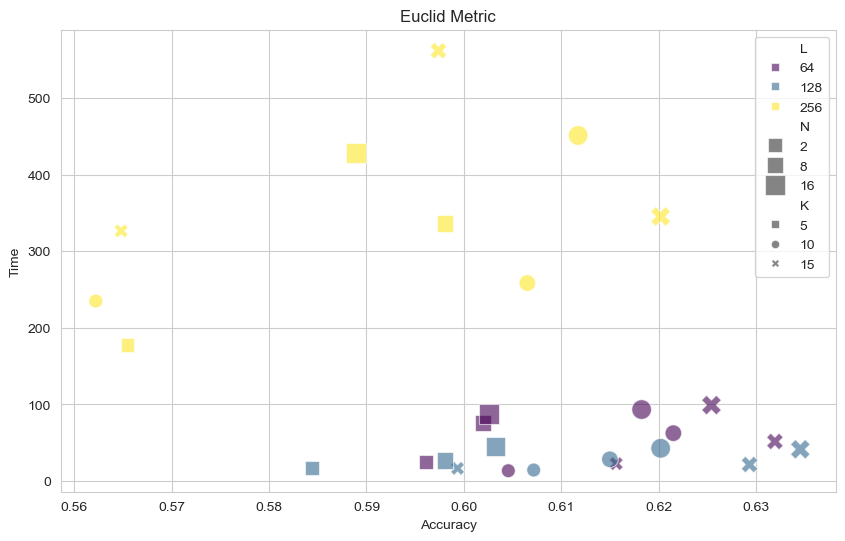

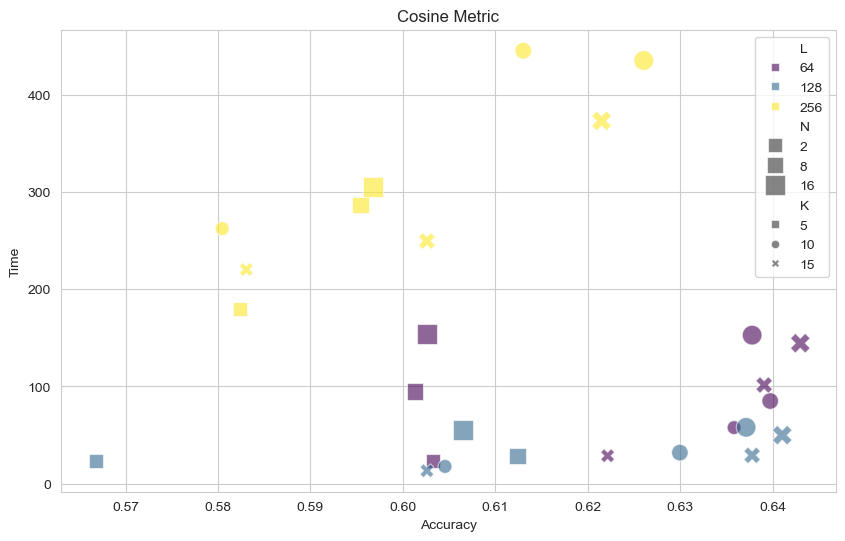

In [25]:
results = {(64, 2, 5, 'euclid'): {'accuracy': 0.5960912052117264, 'time': 24.61885380744934}, (64, 2, 5, 'cosine'): {'accuracy': 0.603257328990228, 'time': 22.938100814819336}, (64, 2, 10, 'euclid'): {'accuracy': 0.6045602605863192, 'time': 13.467969417572021}, (64, 2, 10, 'cosine'): {'accuracy': 0.6358306188925081, 'time': 57.64990282058716}, (64, 2, 15, 'euclid'): {'accuracy': 0.6156351791530945, 'time': 22.726911306381226}, (64, 2, 15, 'cosine'): {'accuracy': 0.6221498371335505, 'time': 28.7292582988739}, (64, 8, 5, 'euclid'): {'accuracy': 0.6019543973941368, 'time': 75.80211687088013}, (64, 8, 5, 'cosine'): {'accuracy': 0.6013029315960912, 'time': 94.78130793571472}, (64, 8, 10, 'euclid'): {'accuracy': 0.6214983713355049, 'time': 62.507568359375}, (64, 8, 10, 'cosine'): {'accuracy': 0.6397394136807818, 'time': 84.98335456848145}, (64, 8, 15, 'euclid'): {'accuracy': 0.6319218241042345, 'time': 51.65255784988403}, (64, 8, 15, 'cosine'): {'accuracy': 0.6390879478827362, 'time': 101.42146253585815}, (64, 16, 5, 'euclid'): {'accuracy': 0.6026058631921825, 'time': 87.87476873397827}, (64, 16, 5, 'cosine'): {'accuracy': 0.6026058631921825, 'time': 153.76025557518005}, (64, 16, 10, 'euclid'): {'accuracy': 0.6182410423452769, 'time': 93.36437702178955}, (64, 16, 10, 'cosine'): {'accuracy': 0.637785016286645, 'time': 152.69060444831848}, (64, 16, 15, 'euclid'): {'accuracy': 0.6254071661237784, 'time': 99.14065146446228}, (64, 16, 15, 'cosine'): {'accuracy': 0.6429967426710098, 'time': 144.37975645065308}, (128, 2, 5, 'euclid'): {'accuracy': 0.5843648208469056, 'time': 16.8671395778656}, (128, 2, 5, 'cosine'): {'accuracy': 0.5667752442996743, 'time': 23.088200569152832}, (128, 2, 10, 'euclid'): {'accuracy': 0.6071661237785017, 'time': 14.384968280792236}, (128, 2, 10, 'cosine'): {'accuracy': 0.6045602605863192, 'time': 17.734903812408447}, (128, 2, 15, 'euclid'): {'accuracy': 0.5993485342019544, 'time': 16.556803941726685}, (128, 2, 15, 'cosine'): {'accuracy': 0.6026058631921825, 'time': 13.323764324188232}, (128, 8, 5, 'euclid'): {'accuracy': 0.5980456026058631, 'time': 27.06729817390442}, (128, 8, 5, 'cosine'): {'accuracy': 0.6123778501628665, 'time': 28.310436487197876}, (128, 8, 10, 'euclid'): {'accuracy': 0.6149837133550489, 'time': 28.34497857093811}, (128, 8, 10, 'cosine'): {'accuracy': 0.6299674267100978, 'time': 31.942339658737183}, (128, 8, 15, 'euclid'): {'accuracy': 0.6293159609120521, 'time': 21.570100784301758}, (128, 8, 15, 'cosine'): {'accuracy': 0.637785016286645, 'time': 29.112306594848633}, (128, 16, 5, 'euclid'): {'accuracy': 0.603257328990228, 'time': 45.2100670337677}, (128, 16, 5, 'cosine'): {'accuracy': 0.606514657980456, 'time': 55.45202159881592}, (128, 16, 10, 'euclid'): {'accuracy': 0.6201954397394137, 'time': 42.76470232009888}, (128, 16, 10, 'cosine'): {'accuracy': 0.6371335504885993, 'time': 57.937888622283936}, (128, 16, 15, 'euclid'): {'accuracy': 0.634527687296417, 'time': 41.43756341934204}, (128, 16, 15, 'cosine'): {'accuracy': 0.641042345276873, 'time': 49.876665115356445}, (256, 2, 5, 'euclid'): {'accuracy': 0.5654723127035831, 'time': 177.14855098724365}, (256, 2, 5, 'cosine'): {'accuracy': 0.5824104234527687, 'time': 179.3382260799408}, (256, 2, 10, 'euclid'): {'accuracy': 0.5622149837133551, 'time': 235.0748996734619}, (256, 2, 10, 'cosine'): {'accuracy': 0.5804560260586319, 'time': 262.19562244415283}, (256, 2, 15, 'euclid'): {'accuracy': 0.5648208469055375, 'time': 326.68050622940063}, (256, 2, 15, 'cosine'): {'accuracy': 0.5830618892508144, 'time': 220.1879427433014}, (256, 8, 5, 'euclid'): {'accuracy': 0.5980456026058631, 'time': 336.16090202331543}, (256, 8, 5, 'cosine'): {'accuracy': 0.5954397394136808, 'time': 286.43207907676697}, (256, 8, 10, 'euclid'): {'accuracy': 0.606514657980456, 'time': 258.5306091308594}, (256, 8, 10, 'cosine'): {'accuracy': 0.613029315960912, 'time': 445.07422518730164}, (256, 8, 15, 'euclid'): {'accuracy': 0.5973941368078176, 'time': 561.9977328777313}, (256, 8, 15, 'cosine'): {'accuracy': 0.6026058631921825, 'time': 249.47272324562073}, (256, 16, 5, 'euclid'): {'accuracy': 0.5889250814332248, 'time': 428.03207778930664}, (256, 16, 5, 'cosine'): {'accuracy': 0.596742671009772, 'time': 304.70144963264465}, (256, 16, 10, 'euclid'): {'accuracy': 0.6117263843648209, 'time': 451.31062722206116}, (256, 16, 10, 'cosine'): {'accuracy': 0.6260586319218241, 'time': 435.0277695655823}, (256, 16, 15, 'euclid'): {'accuracy': 0.6201954397394137, 'time': 345.5001907348633}, (256, 16, 15, 'cosine'): {'accuracy': 0.6214983713355049, 'time': 372.90727162361145}}

# Preprocessing data to fit the visualization requirements
data_euclid = {'Accuracy': [], 'Time': [], 'L': [], 'N': [], 'K': []}
data_cosine = {'Accuracy': [], 'Time': [], 'L': [], 'N': [], 'K': []}

for (l, n, k, m), values in results.items():
    if m == 'euclid':
        data_euclid['Accuracy'].append(values['accuracy'])
        data_euclid['Time'].append(values['time'])
        data_euclid['L'].append(l)
        data_euclid['N'].append(n)
        data_euclid['K'].append(k)
    elif m == 'cosine':
        data_cosine['Accuracy'].append(values['accuracy'])
        data_cosine['Time'].append(values['time'])
        data_cosine['L'].append(l)
        data_cosine['N'].append(n)
        data_cosine['K'].append(k)

df_euclid = pd.DataFrame(data_euclid)
df_cosine = pd.DataFrame(data_cosine)

# Custom marker function
def custom_marker(k):
    if k == 5:
        return 's'  # square
    elif k == 10:
        return 'o'  # circle
    else:
        return 'X'  # cross

# Plotting for Euclid
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_euclid, x='Accuracy', y='Time', style='K', hue='L', size='N',
                palette='viridis', markers={5: 's', 10: 'o', 15: 'X'}, sizes=(100, 200),
                alpha=0.6).set_title('Euclid Metric')
plt.grid(True)
plt.show()

plt.show()
# Plotting for Cosine
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cosine, x='Accuracy', y='Time', style='K', hue='L', size='N',
                palette='viridis', markers={5: 's', 10: 'o', 15: 'X'}, sizes=(100, 200),
                alpha=0.6).set_title('Cosine Metric')
plt.grid(True)
plt.show() 

In [26]:
filtered_results = {
    config: metrics
    for config, metrics in results.items()
    if metrics['time'] < 40 and metrics['accuracy'] > 0.61
}

# To see the filtered results
for config, metrics in filtered_results.items():
    print(f"Config: {config}, Metrics: {metrics}")


Config: (64, 2, 15, 'euclid'), Metrics: {'accuracy': 0.6156351791530945, 'time': 22.726911306381226}
Config: (64, 2, 15, 'cosine'), Metrics: {'accuracy': 0.6221498371335505, 'time': 28.7292582988739}
Config: (128, 8, 5, 'cosine'), Metrics: {'accuracy': 0.6123778501628665, 'time': 28.310436487197876}
Config: (128, 8, 10, 'euclid'), Metrics: {'accuracy': 0.6149837133550489, 'time': 28.34497857093811}
Config: (128, 8, 10, 'cosine'), Metrics: {'accuracy': 0.6299674267100978, 'time': 31.942339658737183}
Config: (128, 8, 15, 'euclid'), Metrics: {'accuracy': 0.6293159609120521, 'time': 21.570100784301758}
Config: (128, 8, 15, 'cosine'), Metrics: {'accuracy': 0.637785016286645, 'time': 29.112306594848633}


In [27]:
results = find_best_parameters_test([64, 128], [2, 8], [15,20], ["euclid", "cosine"])

Progress: 100%|██████████| 1535/1535 [00:44<00:00, 34.35it/s]


Test accuracy: 0.634527687296417
Test time: 46.30194282531738 seconds


Progress: 100%|██████████| 1535/1535 [01:08<00:00, 22.31it/s]


Test accuracy: 0.6384364820846905
Test time: 70.02456140518188 seconds


Progress: 100%|██████████| 1535/1535 [00:17<00:00, 89.50it/s] 


Test accuracy: 0.6084690553745928
Test time: 18.65501046180725 seconds


Progress: 100%|██████████| 1535/1535 [00:39<00:00, 39.01it/s]


Test accuracy: 0.6390879478827362
Test time: 40.53699445724487 seconds


Progress: 100%|██████████| 1535/1535 [00:51<00:00, 29.89it/s]


Test accuracy: 0.6280130293159609
Test time: 55.99431324005127 seconds


Progress: 100%|██████████| 1535/1535 [01:59<00:00, 12.81it/s]


Test accuracy: 0.6429967426710098
Test time: 125.06455683708191 seconds


Progress: 100%|██████████| 1535/1535 [01:05<00:00, 23.43it/s]


Test accuracy: 0.6260586319218241
Test time: 70.24346208572388 seconds


Progress: 100%|██████████| 1535/1535 [01:19<00:00, 19.31it/s]


Test accuracy: 0.6456026058631922
Test time: 84.92961049079895 seconds


Progress: 100%|██████████| 1535/1535 [00:20<00:00, 73.27it/s] 


Test accuracy: 0.6013029315960912
Test time: 23.78264880180359 seconds


Progress: 100%|██████████| 1535/1535 [00:11<00:00, 131.42it/s]


Test accuracy: 0.6091205211726385
Test time: 13.999635696411133 seconds


Progress: 100%|██████████| 1535/1535 [00:23<00:00, 66.19it/s]


Test accuracy: 0.6071661237785017
Test time: 25.507922649383545 seconds


Progress: 100%|██████████| 1535/1535 [00:15<00:00, 98.85it/s] 


Test accuracy: 0.6188925081433225
Test time: 17.851218223571777 seconds


Progress: 100%|██████████| 1535/1535 [00:20<00:00, 75.69it/s] 


Test accuracy: 0.6254071661237784
Test time: 29.440175533294678 seconds


Progress: 100%|██████████| 1535/1535 [00:24<00:00, 63.43it/s] 


Test accuracy: 0.6319218241042345
Test time: 33.50093460083008 seconds


Progress: 100%|██████████| 1535/1535 [00:20<00:00, 73.21it/s] 


Test accuracy: 0.6280130293159609
Test time: 29.914351224899292 seconds


Progress: 100%|██████████| 1535/1535 [00:40<00:00, 38.34it/s]

Test accuracy: 0.644299674267101
Test time: 49.326022148132324 seconds
Best parameters: (64, 8, 20, 'cosine')
Best accuracy: 0.6456026058631922, Test time: 84.92961049079895 seconds


## Final Test on Validation data
Here we combined training and test data, trained our algorithm and tested on the validation data

In [22]:
def test_accuracy_final(l=128, n=16, cut=15, metric="euclid"):
    """
    Calculate the test accuracy and the test time of the find_matching_songs_multiple_optimized algorithm.

    Parameters:
    - l (int): The number of hash functions to be used in the hashtable generator.
    - n (int): The number of hashtables to be generated.
    - cut (int): The number of nearest neighbors to consider for genre classification.
    - metric (str): The distance metric to be used for genre classification.

    Returns:
    - accuracy (float): The test accuracy of the algorithm.
    - test_time (float): The time taken to test the algorithm in seconds.
    """
    start_time = time.time()  # Start time measurement
    hashtables = hashtable_generator(X_combined, l, n)
    correct = 0
    for index in tqdm(range(len(X_test)), desc="Progress"):
        song = X_test[index]
        genre = find_song_genre(song, X_combined, y_combined, hashtables, l, n, cut, metric)  # Assuming you have this function defined elsewhere
        if genre == y_test.iloc[index]:

            correct += 1


    accuracy = correct / len(X_test)
    end_time = time.time()  # End time measurement
    test_time = end_time - start_time

    print(f"Test accuracy: {accuracy}")
    print(f"Test time: {test_time} seconds")
    return accuracy, test_time

In [23]:
final = test_accuracy_final()

Progress: 100%|██████████| 1535/1535 [00:31<00:00, 48.00it/s]

Test accuracy: 0.6182410423452769
Test time: 51.114471435546875 seconds


## Briefly discuss your implementation of LSH and of the approximate nearest neighbour algorithm.
The implementation of Locality-Sensitive Hashing (LSH) is close to what we discussed in the lecture. The "hashtable_generator" function employs a technique known as dimensionality reduction through hashing, leveraging hyperplanes. As stated before: We use the transpose of the Random Projection Matrix to reduce the dimensionality  and determine the orientation of each track's data relative to the hyperplanes by using the dot Product of the feature matrix and the transposed Random Projection Matrix. 
Then we use the binary representations of the orientations as a bucket and put in the tracks accordingly. 
$ \begin{cases} 
0 & \text{ if } x < 0 \\
1 & \text{ else}
\end{cases}
$ 
We can do this because of $\mathbf{a} \cdot \mathbf{b} = \|\mathbf{a}\| \|\mathbf{b}\| \cos(\theta)$ positive means on one side and negative on the other.
This whole process represents one hashtable. To ascertain the precise neighbors, the algorithm calculates the exact distance between elements within a bucket, returning only those elements that best match the criteria defined by the 'cut' parameter. For situations where an insufficient number of elements are found, further guidance is provided in the dedicated section addressing this scenario.


## Detail how you trained your algorithm and how you performed the hyperparameter optimization. Report tested parameter and the results for these parameters.



## Detail why you settled on a specific choice of l (hash length), n (number of hash tables), k (number of nearest neighbours for the prediction) and similarity measure m.
First for the parameter m we found out that the cosin metrics performs slightly better nthan the euclid in most cases, not sure why, however both are pretty similar still.
k
n
For the paraemter l we see a slight tenedency to be better when making it smaller. However only slight difference and the runtime with a bigger l tends to get a bit bigger **check that**


## Report the classification accuracy of your algorithm on the test set
The final accuracy for the test set we achieved was ___
The best final accurcay for both the test and validation set was ___


## Comment on why the chosen random projection method could be beneficial to drawing from a Gaussian distribution?
keine ahnung lol


## Comment on how the runtime of your approximate nearest neighbor algorithm in comparison to that of an exact nearest neighbor search. (You can estimate runtime forthe latter case.) If your implementation is slower than the exact search, speculate about possible reasons; comment on how these aspects might change when working with larger datasets.
The runtime is better as I see it. As a exact nns would look and compare all elements with a runtime of O(n^2) at least. Our solution uses hashing and then only does the exact nns for the elements which are in the same buckets, which is most of the times only a fraction of the total tracks. Therefore the runtime is much better and it is mmuch better scalable for large datasets as the one here. I think the time for running our algorithm is also pretty quick and i guess the exact search would take at least 10x longer (however would most likly have a equal or better solution), however I think the tradeoff is not to large and worth it. 


## Report how you treat music tracks for which there are less than k other similar tracks.
So if there are not enough close songs found in the bucket we have a mechanism in order to ensure that some meaningful songs are found. 
The k is not to relevant here as we just cut of the similiar tracks and provide the best k tracks. However in the case where there is only 0-2 similar tracks found we search other similar buckets in order to ensure that there are enough options for the distance calculation. This distance calculation then uses the most usefull ones, however if none or too few tracks are found the algorithm will not output the best result. Therefore we came up with this idea. It would also be possible to do this only for the 0 songs found case, as else there is an expcetion in the program. Alterantive solution would be to just output a random genre for cases where no song is found but that is a bit to boring. 


## How much time did you spend on the assignment (including the writing of the report; please provide an average for all of your team members)? This will not be used for grading.
About 30 hours per person so 60 in total for both us 

## Who did what? This will not be used for grading. This part is meant for you as a group to reflect on whether you shared the workload fairly and make adjustments for the next assignment if you observe imbalances.
Nenad did the hashtable generator in detail and looked into the theoretical part. While Alex did all of the validation and test scores. The rest was done pretty much together.


    {(64, 2, 5, 'euclid'): {'accuracy': 0.5960912052117264, 'time': 24.61885380744934}, (64, 2, 5, 'cosine'): {'accuracy': 0.603257328990228, 'time': 22.938100814819336}, (64, 2, 10, 'euclid'): {'accuracy': 0.6045602605863192, 'time': 13.467969417572021}, (64, 2, 10, 'cosine'): {'accuracy': 0.6358306188925081, 'time': 57.64990282058716}, (64, 2, 15, 'euclid'): {'accuracy': 0.6156351791530945, 'time': 22.726911306381226}, (64, 2, 15, 'cosine'): {'accuracy': 0.6221498371335505, 'time': 28.7292582988739}, (64, 8, 5, 'euclid'): {'accuracy': 0.6019543973941368, 'time': 75.80211687088013}, (64, 8, 5, 'cosine'): {'accuracy': 0.6013029315960912, 'time': 94.78130793571472}, (64, 8, 10, 'euclid'): {'accuracy': 0.6214983713355049, 'time': 62.507568359375}, (64, 8, 10, 'cosine'): {'accuracy': 0.6397394136807818, 'time': 84.98335456848145}, (64, 8, 15, 'euclid'): {'accuracy': 0.6319218241042345, 'time': 51.65255784988403}, (64, 8, 15, 'cosine'): {'accuracy': 0.6390879478827362, 'time': 101.42146253585815}, (64, 16, 5, 'euclid'): {'accuracy': 0.6026058631921825, 'time': 87.87476873397827}, (64, 16, 5, 'cosine'): {'accuracy': 0.6026058631921825, 'time': 153.76025557518005}, (64, 16, 10, 'euclid'): {'accuracy': 0.6182410423452769, 'time': 93.36437702178955}, (64, 16, 10, 'cosine'): {'accuracy': 0.637785016286645, 'time': 152.69060444831848}, (64, 16, 15, 'euclid'): {'accuracy': 0.6254071661237784, 'time': 99.14065146446228}, (64, 16, 15, 'cosine'): {'accuracy': 0.6429967426710098, 'time': 144.37975645065308}, (128, 2, 5, 'euclid'): {'accuracy': 0.5843648208469056, 'time': 16.8671395778656}, (128, 2, 5, 'cosine'): {'accuracy': 0.5667752442996743, 'time': 23.088200569152832}, (128, 2, 10, 'euclid'): {'accuracy': 0.6071661237785017, 'time': 14.384968280792236}, (128, 2, 10, 'cosine'): {'accuracy': 0.6045602605863192, 'time': 17.734903812408447}, (128, 2, 15, 'euclid'): {'accuracy': 0.5993485342019544, 'time': 16.556803941726685}, (128, 2, 15, 'cosine'): {'accuracy': 0.6026058631921825, 'time': 13.323764324188232}, (128, 8, 5, 'euclid'): {'accuracy': 0.5980456026058631, 'time': 27.06729817390442}, (128, 8, 5, 'cosine'): {'accuracy': 0.6123778501628665, 'time': 28.310436487197876}, (128, 8, 10, 'euclid'): {'accuracy': 0.6149837133550489, 'time': 28.34497857093811}, (128, 8, 10, 'cosine'): {'accuracy': 0.6299674267100978, 'time': 31.942339658737183}, (128, 8, 15, 'euclid'): {'accuracy': 0.6293159609120521, 'time': 21.570100784301758}, (128, 8, 15, 'cosine'): {'accuracy': 0.637785016286645, 'time': 29.112306594848633}, (128, 16, 5, 'euclid'): {'accuracy': 0.603257328990228, 'time': 45.2100670337677}, (128, 16, 5, 'cosine'): {'accuracy': 0.606514657980456, 'time': 55.45202159881592}, (128, 16, 10, 'euclid'): {'accuracy': 0.6201954397394137, 'time': 42.76470232009888}, (128, 16, 10, 'cosine'): {'accuracy': 0.6371335504885993, 'time': 57.937888622283936}, (128, 16, 15, 'euclid'): {'accuracy': 0.634527687296417, 'time': 41.43756341934204}, (128, 16, 15, 'cosine'): {'accuracy': 0.641042345276873, 'time': 49.876665115356445}, (256, 2, 5, 'euclid'): {'accuracy': 0.5654723127035831, 'time': 177.14855098724365}, (256, 2, 5, 'cosine'): {'accuracy': 0.5824104234527687, 'time': 179.3382260799408}, (256, 2, 10, 'euclid'): {'accuracy': 0.5622149837133551, 'time': 235.0748996734619}, (256, 2, 10, 'cosine'): {'accuracy': 0.5804560260586319, 'time': 262.19562244415283}, (256, 2, 15, 'euclid'): {'accuracy': 0.5648208469055375, 'time': 326.68050622940063}, (256, 2, 15, 'cosine'): {'accuracy': 0.5830618892508144, 'time': 220.1879427433014}, (256, 8, 5, 'euclid'): {'accuracy': 0.5980456026058631, 'time': 336.16090202331543}, (256, 8, 5, 'cosine'): {'accuracy': 0.5954397394136808, 'time': 286.43207907676697}, (256, 8, 10, 'euclid'): {'accuracy': 0.606514657980456, 'time': 258.5306091308594}, (256, 8, 10, 'cosine'): {'accuracy': 0.613029315960912, 'time': 445.07422518730164}, (256, 8, 15, 'euclid'): {'accuracy': 0.5973941368078176, 'time': 561.9977328777313}, (256, 8, 15, 'cosine'): {'accuracy': 0.6026058631921825, 'time': 249.47272324562073}, (256, 16, 5, 'euclid'): {'accuracy': 0.5889250814332248, 'time': 428.03207778930664}, (256, 16, 5, 'cosine'): {'accuracy': 0.596742671009772, 'time': 304.70144963264465}, (256, 16, 10, 'euclid'): {'accuracy': 0.6117263843648209, 'time': 451.31062722206116}, (256, 16, 10, 'cosine'): {'accuracy': 0.6260586319218241, 'time': 435.0277695655823}, (256, 16, 15, 'euclid'): {'accuracy': 0.6201954397394137, 'time': 345.5001907348633}, (256, 16, 15, 'cosine'): {'accuracy': 0.6214983713355049, 'time': 372.90727162361145}}

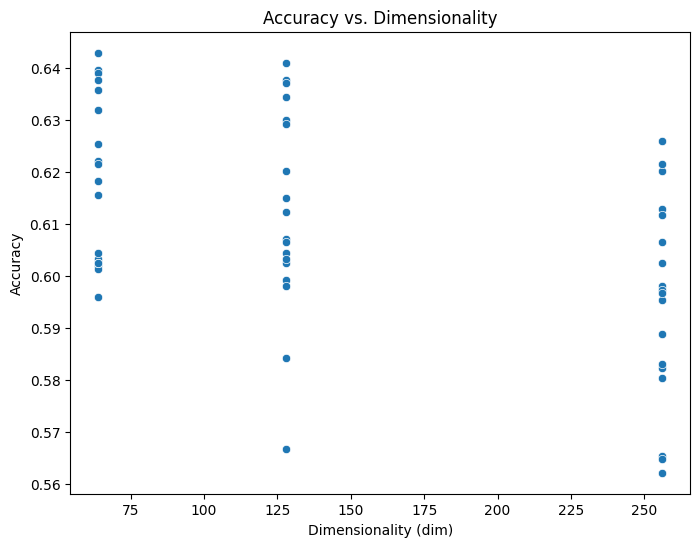

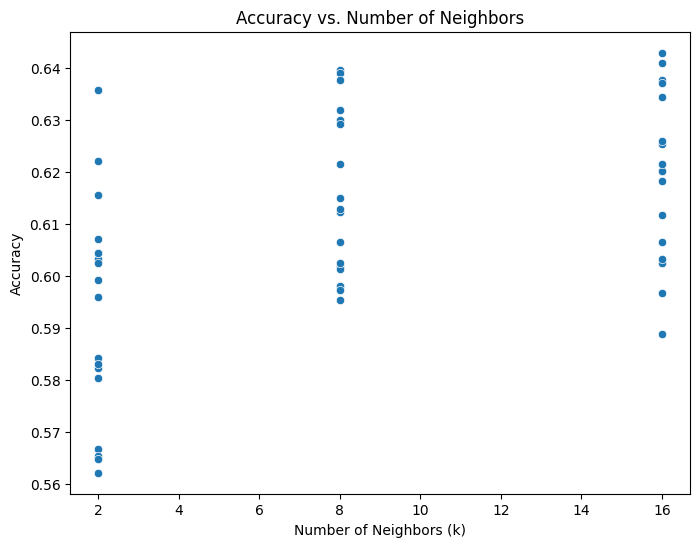

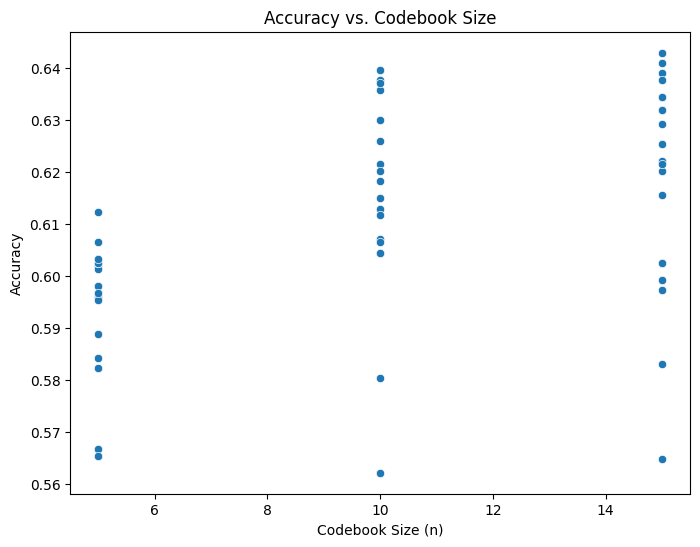

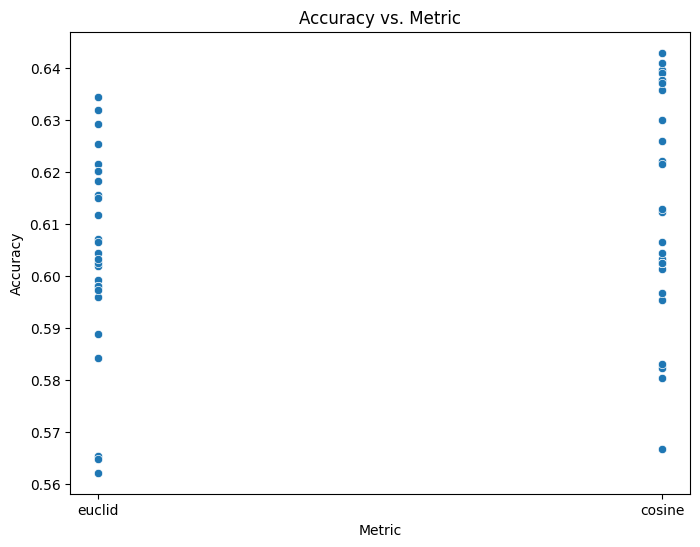

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_dict = {
    (64, 2, 5, 'euclid'): {'accuracy': 0.5960912052117264, 'time': 24.61885380744934},
    (64, 2, 5, 'cosine'): {'accuracy': 0.603257328990228, 'time': 22.938100814819336},
    (64, 2, 10, 'euclid'): {'accuracy': 0.6045602605863192, 'time': 13.467969417572021},
    (64, 2, 10, 'cosine'): {'accuracy': 0.6358306188925081, 'time': 57.64990282058716},
    (64, 2, 15, 'euclid'): {'accuracy': 0.6156351791530945, 'time': 22.726911306381226},
    (64, 2, 15, 'cosine'): {'accuracy': 0.6221498371335505, 'time': 28.7292582988739},
    (64, 8, 5, 'euclid'): {'accuracy': 0.6019543973941368, 'time': 75.80211687088013},
    (64, 8, 5, 'cosine'): {'accuracy': 0.6013029315960912, 'time': 94.78130793571472},
    (64, 8, 10, 'euclid'): {'accuracy': 0.6214983713355049, 'time': 62.507568359375},
    (64, 8, 10, 'cosine'): {'accuracy': 0.6397394136807818, 'time': 84.98335456848145},
    (64, 8, 15, 'euclid'): {'accuracy': 0.6319218241042345, 'time': 51.65255784988403},
    (64, 8, 15, 'cosine'): {'accuracy': 0.6390879478827362, 'time': 101.42146253585815},
    (64, 16, 5, 'euclid'): {'accuracy': 0.6026058631921825, 'time': 87.87476873397827},
    (64, 16, 5, 'cosine'): {'accuracy': 0.6026058631921825, 'time': 153.76025557518005},
    (64, 16, 10, 'euclid'): {'accuracy': 0.6182410423452769, 'time': 93.36437702178955},
    (64, 16, 10, 'cosine'): {'accuracy': 0.637785016286645, 'time': 152.69060444831848},
    (64, 16, 15, 'euclid'): {'accuracy': 0.6254071661237784, 'time': 99.14065146446228},
    (64, 16, 15, 'cosine'): {'accuracy': 0.6429967426710098, 'time': 144.37975645065308},
    (128, 2, 5, 'euclid'): {'accuracy': 0.5843648208469056, 'time': 16.8671395778656},
    (128, 2, 5, 'cosine'): {'accuracy': 0.5667752442996743, 'time': 23.088200569152832},
    (128, 2, 10, 'euclid'): {'accuracy': 0.6071661237785017, 'time': 14.384968280792236},
    (128, 2, 10, 'cosine'): {'accuracy': 0.6045602605863192, 'time': 17.734903812408447},
    (128, 2, 15, 'euclid'): {'accuracy': 0.5993485342019544, 'time': 16.556803941726685},
    (128, 2, 15, 'cosine'): {'accuracy': 0.6026058631921825, 'time': 13.323764324188232},
    (128, 8, 5, 'euclid'): {'accuracy': 0.5980456026058631, 'time': 27.06729817390442},
    (128, 8, 5, 'cosine'): {'accuracy': 0.6123778501628665, 'time': 28.310436487197876},
    (128, 8, 10, 'euclid'): {'accuracy': 0.6149837133550489, 'time': 28.34497857093811},
    (128, 8, 10, 'cosine'): {'accuracy': 0.6299674267100978, 'time': 31.942339658737183},
    (128, 8, 15, 'euclid'): {'accuracy': 0.6293159609120521, 'time': 21.570100784301758},
    (128, 8, 15, 'cosine'): {'accuracy': 0.637785016286645, 'time': 29.112306594848633},
    (128, 16, 5, 'euclid'): {'accuracy': 0.603257328990228, 'time': 45.2100670337677},
    (128, 16, 5, 'cosine'): {'accuracy': 0.606514657980456, 'time': 55.45202159881592},
    (128, 16, 10, 'euclid'): {'accuracy': 0.6201954397394137, 'time': 42.76470232009888},
    (128, 16, 10, 'cosine'): {'accuracy': 0.6371335504885993, 'time': 57.937888622283936},
    (128, 16, 15, 'euclid'): {'accuracy': 0.634527687296417, 'time': 41.43756341934204},
    (128, 16, 15, 'cosine'): {'accuracy': 0.641042345276873, 'time': 49.876665115356445},
    (256, 2, 5, 'euclid'): {'accuracy': 0.5654723127035831, 'time': 177.14855098724365},
    (256, 2, 5, 'cosine'): {'accuracy': 0.5824104234527687, 'time': 179.3382260799408},
    (256, 2, 10, 'euclid'): {'accuracy': 0.5622149837133551, 'time': 235.0748996734619},
    (256, 2, 10, 'cosine'): {'accuracy': 0.5804560260586319, 'time': 262.19562244415283},
    (256, 2, 15, 'euclid'): {'accuracy': 0.5648208469055375, 'time': 326.68050622940063},
    (256, 2, 15, 'cosine'): {'accuracy': 0.5830618892508144, 'time': 220.1879427433014},
    (256, 8, 5, 'euclid'): {'accuracy': 0.5980456026058631, 'time': 336.16090202331543},
    (256, 8, 5, 'cosine'): {'accuracy': 0.5954397394136808, 'time': 286.43207907676697},
    (256, 8, 10, 'euclid'): {'accuracy': 0.606514657980456, 'time': 258.5306091308594},
    (256, 8, 10, 'cosine'): {'accuracy': 0.613029315960912, 'time': 445.07422518730164},
    (256, 8, 15, 'euclid'): {'accuracy': 0.5973941368078176, 'time': 561.9977328777313},
    (256, 8, 15, 'cosine'): {'accuracy': 0.6026058631921825, 'time': 249.47272324562073},
    (256, 16, 5, 'euclid'): {'accuracy': 0.5889250814332248, 'time': 428.03207778930664},
    (256, 16, 5, 'cosine'): {'accuracy': 0.596742671009772, 'time': 304.70144963264465},
    (256, 16, 10, 'euclid'): {'accuracy': 0.6117263843648209, 'time': 451.31062722206116},
    (256, 16, 10, 'cosine'): {'accuracy': 0.6260586319218241, 'time': 435.0277695655823},
    (256, 16, 15, 'euclid'): {'accuracy': 0.6201954397394137, 'time': 345.5001907348633},
    (256, 16, 15, 'cosine'): {'accuracy': 0.6214983713355049, 'time': 372.90727162361145}
}

df = pd.DataFrame.from_dict(data_dict, orient='index')
df.columns = ['accuracy', 'time']
df['dim'], df['k'], df['n'], df['metric'] = zip(*df.index)

# Accuracy vs. Dimensionality (dim)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='dim', y='accuracy', data=df)
plt.xlabel('Bits')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. BIts')
plt.show()

# Accuracy vs. Number of Neighbors (k)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='k', y='accuracy', data=df)
plt.xlabel('Number of Runs (n)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Runs')
plt.show()

# Accuracy vs. Codebook Size (n)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='n', y='accuracy', data=df)
plt.xlabel('Number of Neighbors (k))')
plt.ylabel('Accuracy')
plt.title('Accuracy vs.Number of Neighbors')
plt.show()

# Accuracy vs. Metric (metric)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='metric', y='accuracy', data=df)
plt.xlabel('Metric')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Metric')
plt.show()